In [1]:
import os
import numpy as np
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
tensorflow_seed = 1
tf.random.set_seed(tensorflow_seed)

In [15]:
BASE_DIR = os.path.abspath(os.path.dirname("__file__"))
NUMPY_DIR = os.path.join(BASE_DIR, "data","numpy_arrays")
FACENET_DIR = os.path.join(BASE_DIR, "model_files","facenet_keras.h5")

In [4]:
X1 = np.load(os.path.join(NUMPY_DIR, "X1.npy"))
X2 = np.load(os.path.join(NUMPY_DIR, "X2.npy"))
y = np.load(os.path.join(NUMPY_DIR, "y.npy"))

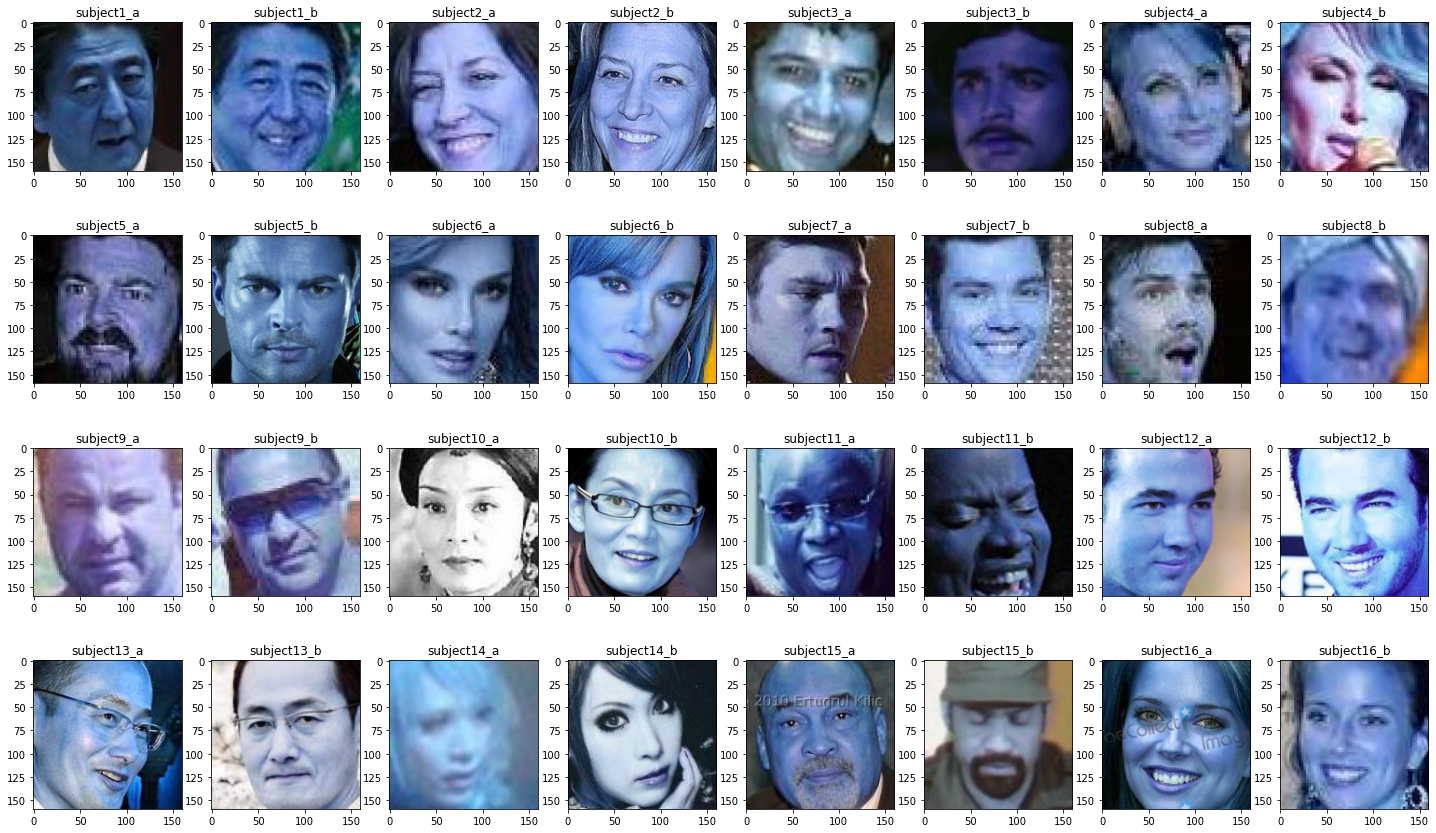

In [13]:
matplotlib.rcParams['figure.figsize'] = (25.0, 15.0)
indices = np.random.randint(0, high=X1.shape[0]//2, size=16, dtype=int).tolist()
pos_sample_1 = X1[indices]
pos_sample_2 = X2[indices]
for i in range(len(indices)):
    plt.subplot(4,8,i*2+1)
    plt.title("subject{}_a".format(i+1))
    plt.imshow(pos_sample_1[i].astype("uint8"))
    plt.subplot(4,8,i*2+2)
    plt.title("subject{}_b".format(i+1))
    plt.imshow(pos_sample_2[i].astype("uint8"))
plt.show()

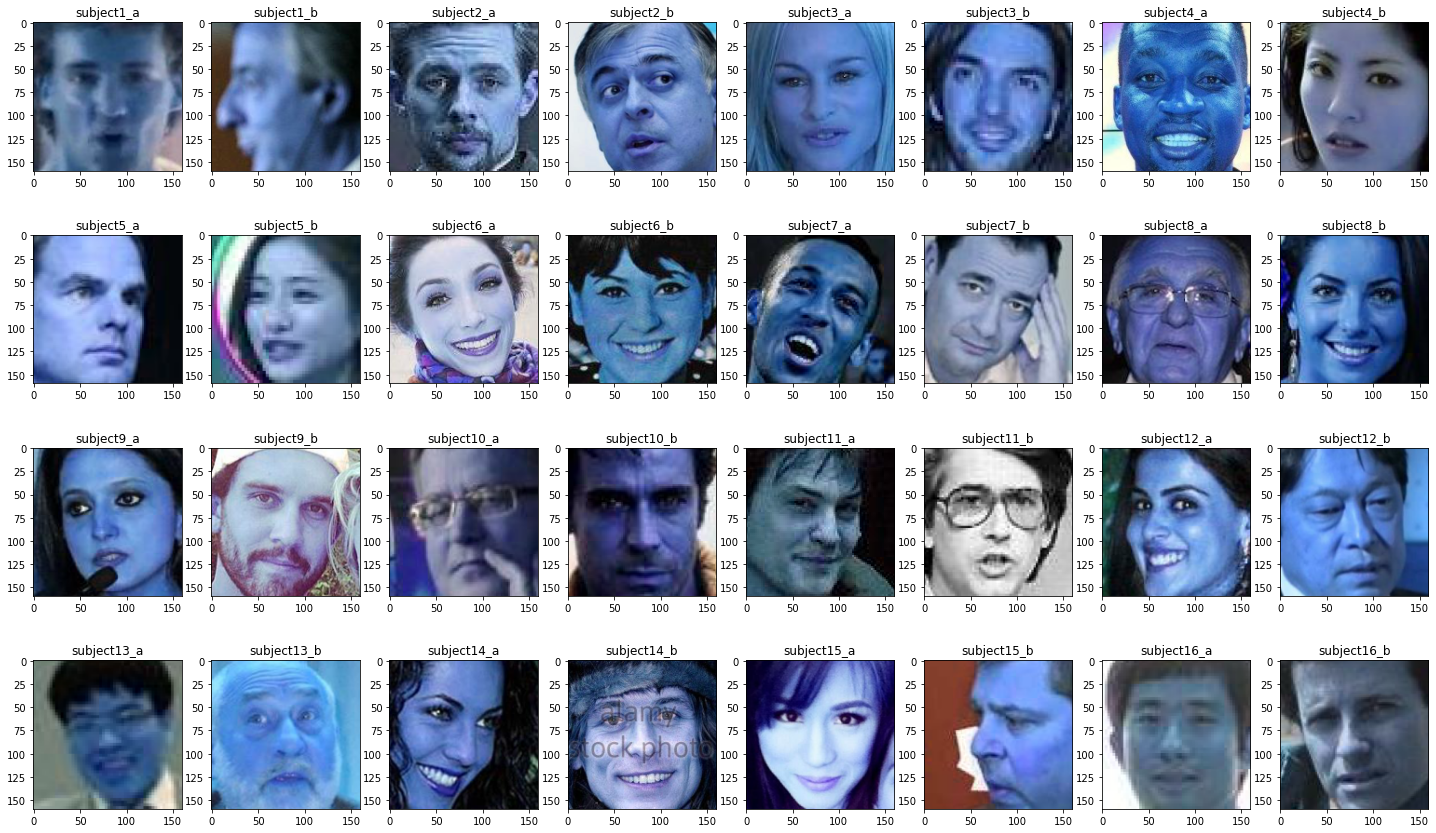

In [14]:
matplotlib.rcParams['figure.figsize'] = (25.0, 15.0)
indices = np.random.randint(X1.shape[0]//2, high=X1.shape[0], size=16, dtype=int).tolist()
pos_sample_1 = X1[indices]
pos_sample_2 = X2[indices]
for i in range(len(indices)):
    plt.subplot(4,8,i*2+1)
    plt.title("subject{}_a".format(i+1))
    plt.imshow(pos_sample_1[i].astype("uint8"))
    plt.subplot(4,8,i*2+2)
    plt.title("subject{}_b".format(i+1))
    plt.imshow(pos_sample_2[i].astype("uint8"))
plt.show()